In [1]:
import random
from copy import deepcopy
from math import log10

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
from matplotlib.axes import Axes
from IPython.display import display
import requests
import os
from dotenv import load_dotenv

In [2]:
# Load environment variables
load_dotenv()

# Access environment variables
subgraph_url = os.environ['SUBGRAPH_URL']
api_host = os.environ['API_HOST']
api_key = os.environ['API_KEY']

print(f"{api_host}")

34.141.236.56


### Get safe balances from subgraph and channel balances from the topology api endpoint 

In [3]:
def get_subgraph_data():
    """
    This function retrieves safe_address-node_address-balance links from the
    specified subgraph using pagination.
    """

    query = """
            query SafeNodeBalance($first: Int, $skip: Int) {
                safes(first: $first, skip: $skip) {
                    registeredNodesInNetworkRegistry {
                    node { id }
                    safe {  id balance { wxHoprBalance }
                    }
                    }
                }
            }
        """

    data = {
        "query": query,
        "variables": {
            "first": 1000,
            "skip": 0,
        },
    }
    subgraph_dict = {}
    more_content_available = True
    pagination_skip_size = 1000

    while more_content_available:
        try:
            response = requests.post(subgraph_url, json=data)

            if response.status_code != 200:
                print(f"Received status code {response.status_code} when querying The Graph API")
                break

            json_data = response.json()

        except requests.exceptions.RequestException:
            print("An error occurred while sending the request to subgraph endpoint")
            return {}
        except ValueError:
            print("An error occurred while parsing the response as JSON from subgraph endpoint")
            return {}
        except Exception:
            print("An unexpected error occurred")
            return {}

        safes = json_data["data"]["safes"]
        for safe in safes:
            for node in safe["registeredNodesInNetworkRegistry"]:
                node_address = node["node"]["id"]
                wxHoprBalance = node["safe"]["balance"]["wxHoprBalance"]
                safe_address = node["safe"]["id"]
                subgraph_dict[node_address] = {
                    "safe_address": safe_address,
                    "wxHOPR_balance": wxHoprBalance,
                }

        # Increment skip for the next iteration
        data["variables"]["skip"] += pagination_skip_size
        more_content_available = len(safes) == pagination_skip_size

    return subgraph_dict

def get_unique_nodeAddress_peerId_aggbalance_links(api_host, api_key):
    """
    Returns a dict containing all unique source_peerId-source_address links.
    """
    channel_url = "http://{}:3001/api/v3/channels/?includingClosed=false&fullTopology=true".format(api_host)
    headers = {'X-Auth-Token': api_key}
    response = requests.request("GET", channel_url, headers=headers)

    if response.status_code != 200:
        print("Could not fetch channel information. Status code: {}".format(response.status_code))
        return {}

    response = response.json()

    if 'all' not in response:
            print("Response does not contain `all`")
            return {}

    peerid_address_aggbalance_links = {}
    for item in response["all"]:
        if "sourcePeerId" not in item or "sourceAddress" not in item:
            print("Response does not contain `source_peerid` or `source_address`")
            continue

        if "status" not in item:
            print("Response does not contain `status`")
            continue

        source_peer_id = item["sourcePeerId"]
        source_address = item["sourceAddress"]
        balance = int(item["balance"]) / 1e18

        if item["status"] != "Open":
            # Other Statuses: "Waiting for commitment", "Closed", "Pending to close"
            # Ensures that nodes must have at least 1 open channel in to receive ct
            continue

        if source_peer_id not in peerid_address_aggbalance_links:
            peerid_address_aggbalance_links[source_peer_id] = {
                "source_node_address": source_address,
                "channels_balance": balance,
            }

        else:
            peerid_address_aggbalance_links[source_peer_id][
                "channels_balance"
            ] += balance

    return peerid_address_aggbalance_links

In [4]:
topology_data = get_unique_nodeAddress_peerId_aggbalance_links(api_host, api_key)

print(len(topology_data))

print_size = 5

for key, value in list(topology_data.items())[:print_size]:
    print(f"{key}: {value}")

387
12D3KooWAAZ3WnaWMuSQnQSFYnwx7g6W725DYmDY1QASZK1nni5B: {'source_node_address': '0xfa73af5609d354acd0f6e51f77c04d228c370813', 'channels_balance': 460.0}
12D3KooWC7Tub3aRmxUM7XjiozW5paXcySN9gWDDvJwNh98DTdUD: {'source_node_address': '0x07a52c8338edef4b6d3a180c1b75815469ff3a46', 'channels_balance': 1312.0}
12D3KooWKn3bLWMymSMznYt3YRrK8cwmYytEzwM1HoDgqkLcmeSu: {'source_node_address': '0x8de95cdc3291152381f24226422ed9c08beec146', 'channels_balance': 3244.1000000000004}
12D3KooWNJyWUuu9M9RNU8zTMyqCA8K1GqJwv8tjHsc2oYsJJajD: {'source_node_address': '0x9925b9846e6e289e1c7f8a0554bf6900757491ec', 'channels_balance': 195.0}
12D3KooWH9rfYNKMkNncYJxS7BH41ThPZUYe3FNkbfmJAa4n5r3x: {'source_node_address': '0x5a5bf3d3ce59cd304f198b86c1a78adfadf31f83', 'channels_balance': 24522.800000000083}


In [5]:
subgraph_data = get_subgraph_data()
print(len(subgraph_data))

print_size = 10

for key, value in list(subgraph_data.items())[:print_size]:
    print(f"{key}: {value}")


543
0xcdd7117148b6f2975815dd39d99bb9ed4553842b: {'safe_address': '0x00133125ccdf4ea1231a47e073c616f358b2d5a8', 'wxHOPR_balance': '25457.979078508447062483'}
0x2168fcd793a3967fa4bdd66f534c4fc811124439: {'safe_address': '0x01f1d2f347ea987b5cf3ed383146feda5265f38a', 'wxHOPR_balance': '47751.363279908780883268'}
0x9261303fe593ca3ced719213a9adfcd13162c9cf: {'safe_address': '0x039e399bf0409e06e0d4dabe6b8589d8f97c0c86', 'wxHOPR_balance': '10151.18031916'}
0x61c479d3715d1afe3080ebe2e8bc24d25ccdc24f: {'safe_address': '0x03ef32709b4931082221bfa5edec3e816c24c53d', 'wxHOPR_balance': '10016.4365034'}
0xed04f9fbf9160793fff7532df3860c70862bff4e: {'safe_address': '0x0420bd44fe87a855a11c9fd42b3f42203b03dec9', 'wxHOPR_balance': '72403.999283247394399044'}
0xfcc30ccecf890362d66194659f4850acbe84b08b: {'safe_address': '0x042ddd9d9b99ed1a08eb5c5a3feae5e7a1732e82', 'wxHOPR_balance': '36149.73322538'}
0x5f2b29d02fc77d50b3de83b507409cdd81290075: {'safe_address': '0x049f8118b5435fd9cda5c393767771adfe5e137c', 'w

### Merge Subgraph and Topology Data 

In [6]:
def merge_topology_subgraph(topology_dict: dict, subgraph_dict: dict):
    """
    Merge metrics and subgraph data with the unique peer IDs, addresses,
    balance links.
    :param: topology_dict: A dict mapping peer IDs to node addresses.
    :param: subgraph_dict: A dict containing subgraph data with safe address as the key.
    :returns: A dict with peer ID as the key and the merged information.
    """
    merged_result = {}

    # Merge based on peer ID with the channel topology as the baseline
    for peer_id, data in topology_dict.items():
        seen_in_subgraph = False

        source_node_address = data["source_node_address"]
        if source_node_address in subgraph_dict:
            subgraph_data = subgraph_dict[source_node_address]
            data["safe_address"] = subgraph_data["safe_address"]
            data["safe_balance"] = float(subgraph_data["wxHOPR_balance"])
            data["total_balance"] = data["channels_balance"] + data["safe_balance"]

            seen_in_subgraph = True
            # print(f"Source node address for {peer_id} found in subgraph")

        if seen_in_subgraph:
            merged_result[peer_id] = data

    return merged_result

In [7]:
merged_data = merge_topology_subgraph(topology_data, subgraph_data)
print(len(merged_data))

print_size = 5

for key, value in list(merged_data.items())[:print_size]:
    print(f"{key}: {value}")


387
12D3KooWAAZ3WnaWMuSQnQSFYnwx7g6W725DYmDY1QASZK1nni5B: {'source_node_address': '0xfa73af5609d354acd0f6e51f77c04d228c370813', 'channels_balance': 460.0, 'safe_address': '0x8832376a388cfcb58dab0cce249f65b86041e4bc', 'safe_balance': 9858.00709201485, 'total_balance': 10318.00709201485}
12D3KooWC7Tub3aRmxUM7XjiozW5paXcySN9gWDDvJwNh98DTdUD: {'source_node_address': '0x07a52c8338edef4b6d3a180c1b75815469ff3a46', 'channels_balance': 1312.0, 'safe_address': '0x84600a20ea20d4cc139e0483650320d8d26c03d1', 'safe_balance': 15390.0656126, 'total_balance': 16702.0656126}
12D3KooWKn3bLWMymSMznYt3YRrK8cwmYytEzwM1HoDgqkLcmeSu: {'source_node_address': '0x8de95cdc3291152381f24226422ed9c08beec146', 'channels_balance': 3244.1000000000004, 'safe_address': '0x4d219619fa660c02236c89e5de46843bdeb41233', 'safe_balance': 75252.4474634, 'total_balance': 78496.54746340001}
12D3KooWNJyWUuu9M9RNU8zTMyqCA8K1GqJwv8tjHsc2oYsJJajD: {'source_node_address': '0x9925b9846e6e289e1c7f8a0554bf6900757491ec', 'channels_balance':

### Exclude CT Nodes and apply Balance Split  

In [8]:
def exclude_elements(source_data: dict, blacklist: list):
    """
    Removes elements from a dictionary based on a blacklist.
    :param: source_data (dict): The dictionary to be updated.
    :param: blacklist (list): A list containing the keys to be removed.
    :returns: nothing.
    """

    for key in blacklist:
        if key not in source_data:
            continue
        del source_data[key]
        print(f"Excluded {key} from the dataset.")

    return source_data

def allow_many_node_per_safe(input_dict: dict):
    """
    Split the stake managed by a safe address equaly between the nodes
    that the safe manages.
    :param: input_dict: dictionary containing peerID, nodeAddress, safeAdress
        and total balance.
    :returns: nothing.
    """
    safe_address_counts = {}

    # Calculate the number of safe_addresses related to a node address
    for value in input_dict.values():
        safe_address = value["safe_address"]

        if safe_address not in safe_address_counts:
            safe_address_counts[safe_address] = 0

        safe_address_counts[safe_address] += 1

    # Update the input_dict with the calculated splitted_stake
    for value in input_dict.values():
        safe_address = value["safe_address"]
        channels_balance = value["channels_balance"]
        safe_balance = value["safe_balance"]
        value["safe_address_count"] = safe_address_counts[safe_address]

        value["splitted_stake"] = (
            safe_balance / value["safe_address_count"]
        ) + channels_balance

    return input_dict

In [9]:
blacklist = ["12D3KooWH9rfYNKMkNncYJxS7BH41ThPZUYe3FNkbfmJAa4n5r3x", "12D3KooWL16nW1Z2dLvyZWzr9ZZwoLTeuSfaKSeX2BjucHwSoEwJ",
            "12D3KooWNYi2kG5cdeEUBvjemZRUkPVmAeXsSGVrX9QHnEiMfh8w","12D3KooWGyY39vD8J2VGEDjTCD3eEyvV4YrnKM9NCQa6SYJKczrR"]

exluded_elements_merged_data = exclude_elements(merged_data, blacklist)

print(len(exluded_elements_merged_data))

Excluded 12D3KooWH9rfYNKMkNncYJxS7BH41ThPZUYe3FNkbfmJAa4n5r3x from the dataset.
Excluded 12D3KooWL16nW1Z2dLvyZWzr9ZZwoLTeuSfaKSeX2BjucHwSoEwJ from the dataset.
Excluded 12D3KooWNYi2kG5cdeEUBvjemZRUkPVmAeXsSGVrX9QHnEiMfh8w from the dataset.
Excluded 12D3KooWGyY39vD8J2VGEDjTCD3eEyvV4YrnKM9NCQa6SYJKczrR from the dataset.
383


In [10]:
output_data = allow_many_node_per_safe(exluded_elements_merged_data)

print(len(output_data))

print_size = 5

for key, value in list(output_data.items())[:print_size]:
    print(f"{key}: {value}")

383
12D3KooWAAZ3WnaWMuSQnQSFYnwx7g6W725DYmDY1QASZK1nni5B: {'source_node_address': '0xfa73af5609d354acd0f6e51f77c04d228c370813', 'channels_balance': 460.0, 'safe_address': '0x8832376a388cfcb58dab0cce249f65b86041e4bc', 'safe_balance': 9858.00709201485, 'total_balance': 10318.00709201485, 'safe_address_count': 1, 'splitted_stake': 10318.00709201485}
12D3KooWC7Tub3aRmxUM7XjiozW5paXcySN9gWDDvJwNh98DTdUD: {'source_node_address': '0x07a52c8338edef4b6d3a180c1b75815469ff3a46', 'channels_balance': 1312.0, 'safe_address': '0x84600a20ea20d4cc139e0483650320d8d26c03d1', 'safe_balance': 15390.0656126, 'total_balance': 16702.0656126, 'safe_address_count': 1, 'splitted_stake': 16702.0656126}
12D3KooWKn3bLWMymSMznYt3YRrK8cwmYytEzwM1HoDgqkLcmeSu: {'source_node_address': '0x8de95cdc3291152381f24226422ed9c08beec146', 'channels_balance': 3244.1000000000004, 'safe_address': '0x4d219619fa660c02236c89e5de46843bdeb41233', 'safe_balance': 75252.4474634, 'total_balance': 78496.54746340001, 'safe_address_count': 1

In [11]:
# Create a DataFrame from the dictionary
df = pd.DataFrame.from_dict(output_data, orient='index')

# Reset the index
df.reset_index(inplace=True)

# Rename the columns
df.columns = ['peer_id', 'source_node_address', 'channels_balance', 'safe_address', 'safe_balance', 'total_balance', 'safe_address_count', 'splitted_stake']

### TODO 

The dataframe `df` contains information about the most recent stake of a node. This information can be used to fit the already existing simulation framework.  

In [26]:
def stake_transformation(values, slope, curvature, threshold):
    transformed_stakes = []

    for x in values:
        if x <= 10e3:
            transformed_stakes.append(1e-20)
        elif x <= threshold:
            f_x = slope * x
            transformed_stakes.append(f_x)
        else:
            g_x = slope * threshold  + (x - threshold) ** (1 / curvature)
            transformed_stakes.append(g_x)

    return transformed_stakes

def compute_probabilities(stakes: list):
    sum_stakes = sum(stakes)
    return [s / sum_stakes for s in stakes]

def compute_rewards(probabilities: list, budget: int):
    return [p * budget for p in probabilities]

def compute_apy(opt: dict, data: list, percentage: bool = False, average: bool = True, on_stake: bool = False):
    transformed_stakes = stake_transformation(data, **opt["model_arguments"])

    probabilities = compute_probabilities(transformed_stakes)

    rewards = compute_rewards(probabilities, opt["budget"])

    if percentage:
        factor = 100
    else:
        factor = 1

    period_apy = [r / s for r, s in zip(rewards, data if on_stake else transformed_stakes)]
    yearly_apy = [apy * 12 / opt["period_in_months"] * factor for apy in period_apy]

    apy = sum(yearly_apy) / len(yearly_apy) if average else yearly_apy

    return apy

def factor_and_prefix(value):
    factor = int(int(log10(value))/3)*3
    if factor < 3:
        prefix = ""
    elif factor < 6:
        prefix = "k"
    elif factor < 9:
        prefix = "M"

    return 10**factor, prefix

def probabilistic_apy(data: list, options: list[dict]):
    result_template = {"apys": [], "average": 0}

    results = [deepcopy(result_template) for _ in range(len(options))]

    for idx, opt in enumerate(options):
        tf_stakes = stake_transformation(data, **opt["model_arguments"])

        apy = compute_apy(opt, tf_stakes, percentage=False)

        results[idx]["apy"] = apy
    return results

def generate_simulation_graph(data:list, options: list[dict], title: str = None, cols:int=3):
    rows = int(len(options) / cols + 0.5)
    if rows * cols < len(options):
        rows += 1

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*6,rows*6), dpi=300)

    axes = [axes] if isinstance(axes, Axes) else axes.flatten()


    results = probabilistic_apy(data, options)
    

    for opt, result, ax in zip(options, results, axes):
        max_stakes = max(data)
        stakes = np.linspace(0, max_stakes, 1000)
        factor, prefix = factor_and_prefix(stakes[-1])

        tf_stakes = stake_transformation(stakes, **opt["model_arguments"])


        tf_data_points = stake_transformation(data, **opt["model_arguments"])

        stakes_for_plt = [s/factor for s in stakes]
        tf_stakes_for_plt = [s/factor for s in tf_stakes]

        data_points_for_plt = [s/factor for s in data]
        tf_data_points_for_plt = [s/factor for s in tf_data_points]

        messages_per_second = opt["budget"] / (opt["ticket_options"]["price"] * opt["ticket_options"]["winning_probability"]) / (opt["period_in_months"] * 30 * 24 * 60 * 60)


        ax.plot(stakes_for_plt, tf_stakes_for_plt, label=opt["legend"])
        ax.scatter(data_points_for_plt, tf_data_points_for_plt, s=12, alpha=0.8, c="#ff7f0e")

        ax.set_xlabel(f"Stake (/{prefix}/HOPR)")
        ax.set_ylabel(f"Transformed stake (/{prefix}/HOPR)")
        ax.text(0.1,
                0.8,
                f"APY: {result['apy']:.2%}",
                transform=ax.transAxes,
                horizontalalignment='left',
                bbox=dict(facecolor='red', alpha=0.5),)
        ax.text(0.1,
                0.7,
                f"Messages/s: {messages_per_second:.2f}",
                transform=ax.transAxes,
                horizontalalignment='left',
                bbox=dict(facecolor='blue', alpha=0.5),)

        # set the x and y scale equal
        ax.set_aspect('equal', adjustable='box')
        ax.set_ylim(ax.get_xlim())

        ax.legend()
        ax.grid()

    # remove unused axes
    for ax in axes[len(options):]:
        ax.remove()

    if title:
        if len(options) == 1:
            plt.title(title, fontsize=10)
        else:
            fig.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()

def generate_simulation_graph_simple(options: list[dict], steps: int, title: str = None):
    rows = 1
    cols = int(len(options) / rows + 0.5)
    if rows * cols < len(options):
        cols += 1

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*6,rows*6), dpi=300)

    axes = [axes] if isinstance(axes, Axes) else axes.flatten()

    for opt, ax in zip(options, axes):
        stakes = np.linspace(0, 1e6, steps)

        tf_stakes = stake_transformation(stakes, **opt["model_arguments"])

        ax.plot(stakes, tf_stakes)
        ax.set_xlabel(f"Stakes (HOPR)")
        ax.set_ylabel(f"Transformed Stakes (HOPR)")

        # set the x and y scale equal
        ax.set_aspect('equal', adjustable='box')
        ax.set_ylim(ax.get_xlim())

        ax.grid()

    # remove unused axes
    for ax in axes[len(options):]:
        ax.remove()

    if title:
        fig.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()

def generate_simulation_table(datas:list[list], options: list[dict], imposed_counts: list, steps: int = 200):

    apy_array = []
    messages_array = []
    combined_array = []

    for opt in options:
        temp_apy_array = []
        temp_messages_array = []
        temp_combined_array = []

        for count in imposed_counts:
            opt["data_count"] = count

            result = probabilistic_apy(datas, [opt], steps)[0]

            messages_per_second = opt["budget"] / (opt["ticket_options"]["price"] * opt["ticket_options"]["winning_probability"]) / (opt["period_in_months"] * 30 * 24 * 60 * 60)

            temp_apy_array.append(f"{result['average']:.2%}")
            temp_messages_array.append(f"{messages_per_second:.2f}")
            temp_combined_array.append(f"{result['average']:.2%} / {messages_per_second:.2f}m/s")

        apy_array.append(temp_apy_array)
        messages_array.append(temp_messages_array)
        combined_array.append(temp_combined_array)

    return apy_array, messages_array, combined_array

In [31]:
data = df["splitted_stake"].to_list()

# aim for 15% APY
prefered = {
    "budget": 100_000, # fixed
    "period_in_months": 1, # fixed
    "model_arguments": {
        "slope": 1, # fixed
        "curvature":1.4,
        "threshold":75e3,
    },
    "ticket_options": { # fixed
        "price": 1, # fixed
        "winning_probability": 1, # fixed
    },
    "legend": "",
}


### Economic model

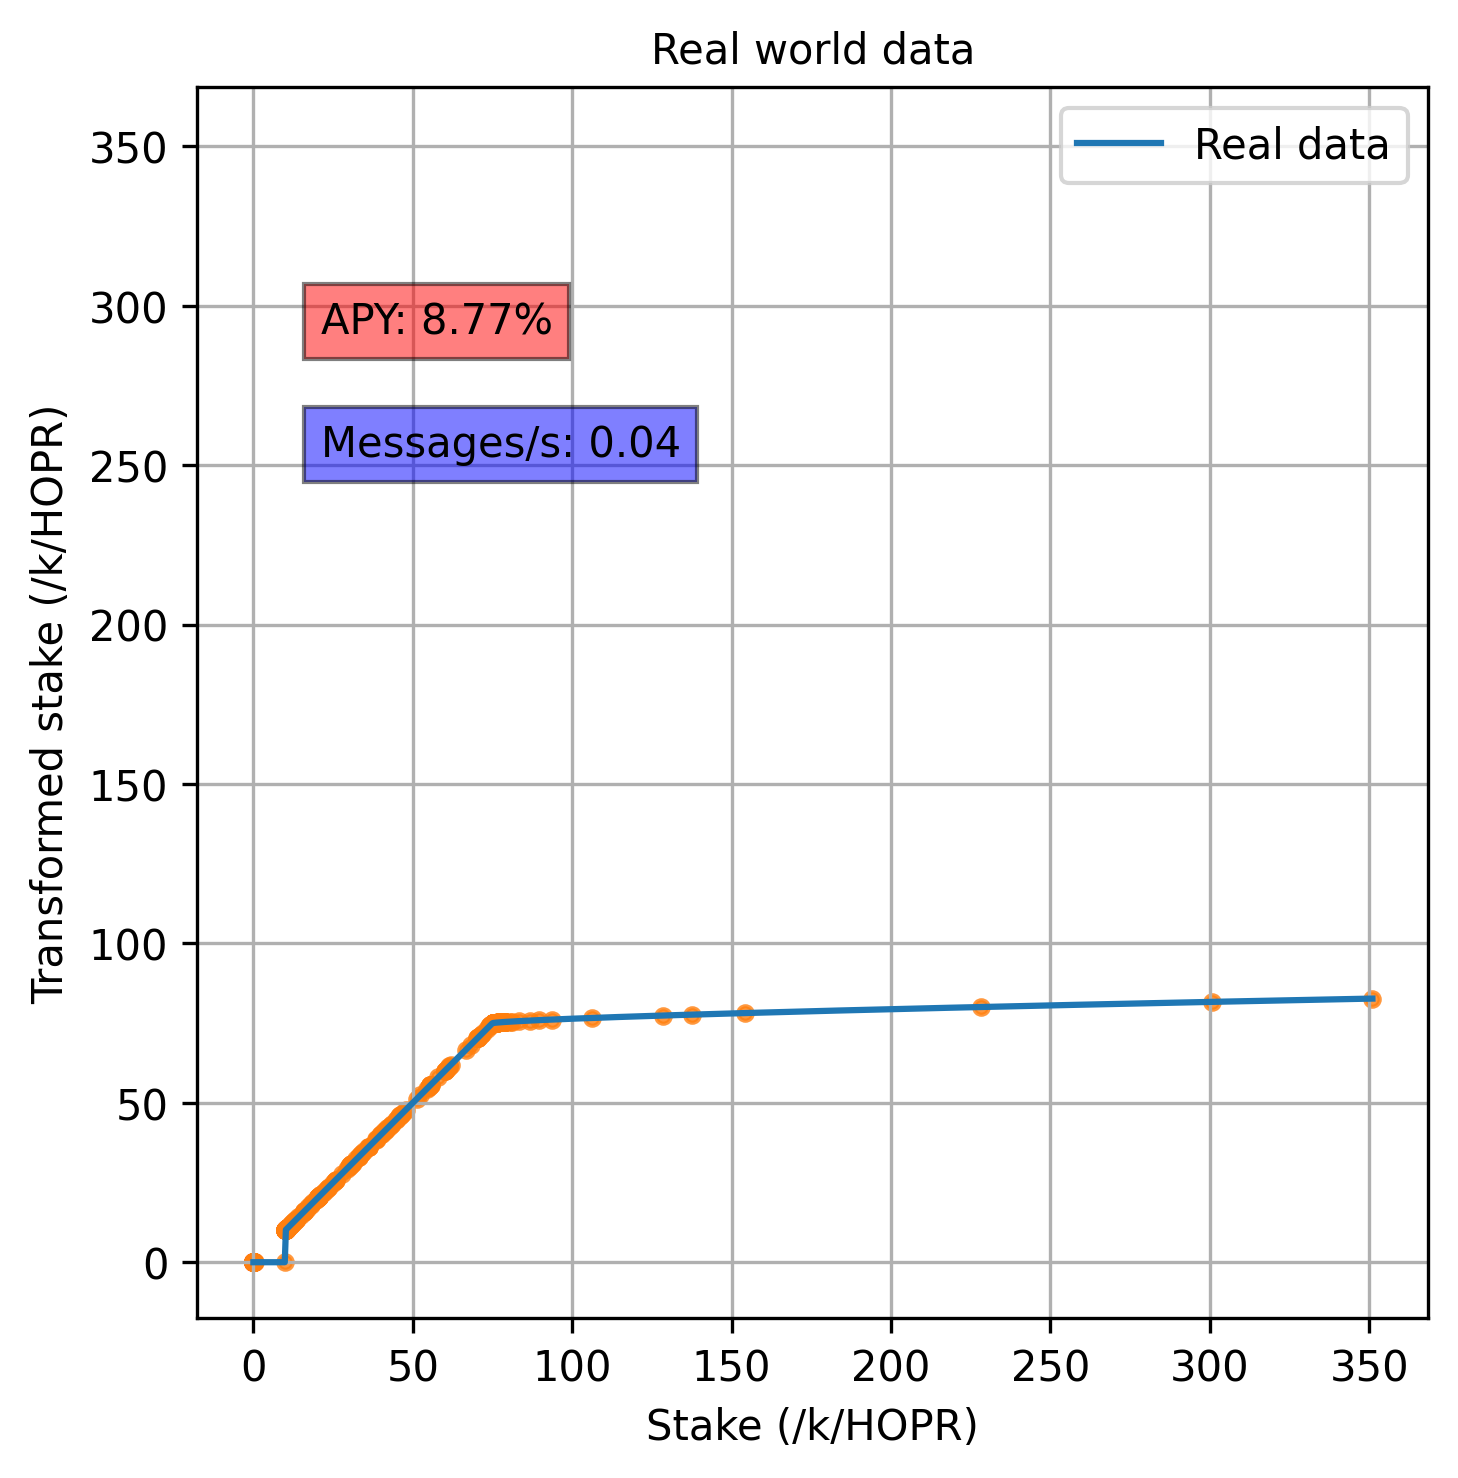

In [32]:
prefered_vars = [deepcopy(prefered) for _ in range(1)]

prefered_vars[-1]["legend"] = "(long-term)"

for idx, opt in enumerate(prefered_vars):
    opt["legend"] = "Real data"

generate_simulation_graph(data, prefered_vars, title="Real world data")

In [33]:
print(f"min stake: {min(data):.2f} HOPR")
print(f"max stake: {max(data):.2f} HOPR")
print(f"average stake: {np.mean(data):.2f} HOPR")
print(f"median stake: {np.median(data):.2f} HOPR")


min stake: 1.00 HOPR
max stake: 351004.55 HOPR
average stake: 38498.90 HOPR
median stake: 23606.89 HOPR


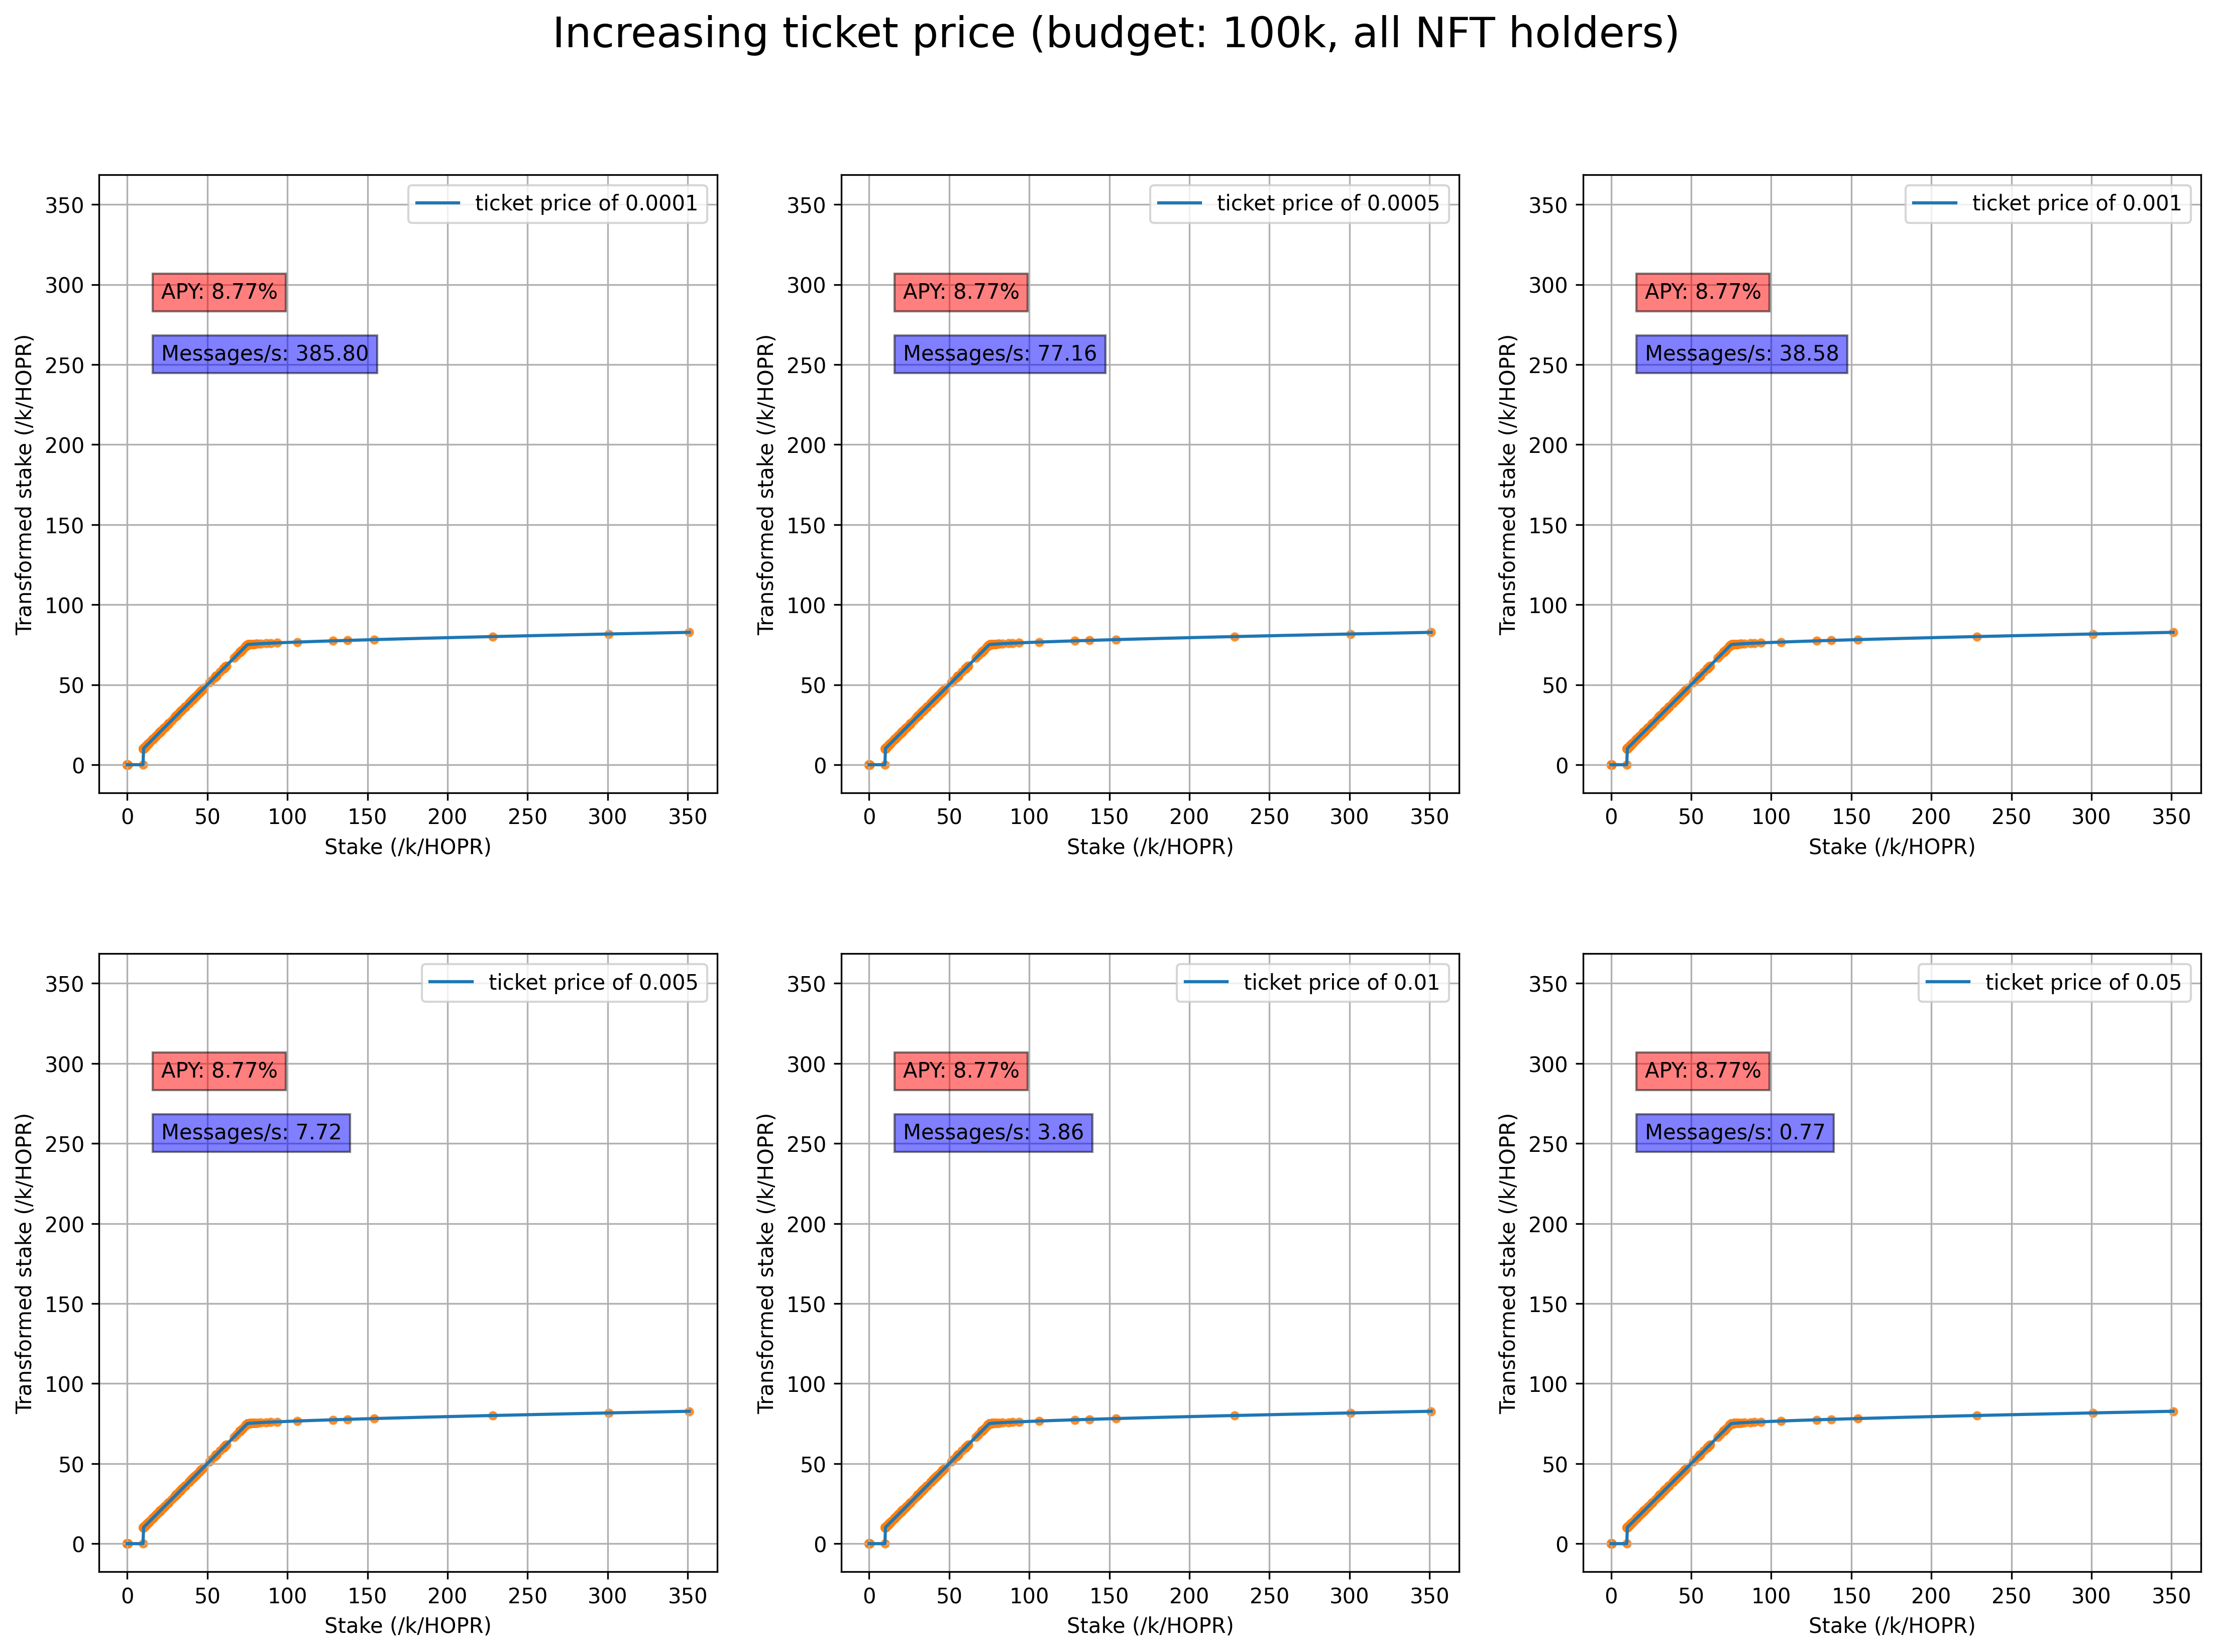

In [34]:
ticket_prices = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
options = [deepcopy(prefered) for _ in range(len(ticket_prices))]

for opt, ticket_price in zip(options, ticket_prices):
    opt["ticket_options"]["price"] = ticket_price
    opt["legend"] = f"ticket price of {ticket_price}"

generate_simulation_graph(data, options, title=f"Increasing ticket price (budget: {options[0]['budget']/1000:.0f}k, all NFT holders)")

### Table results

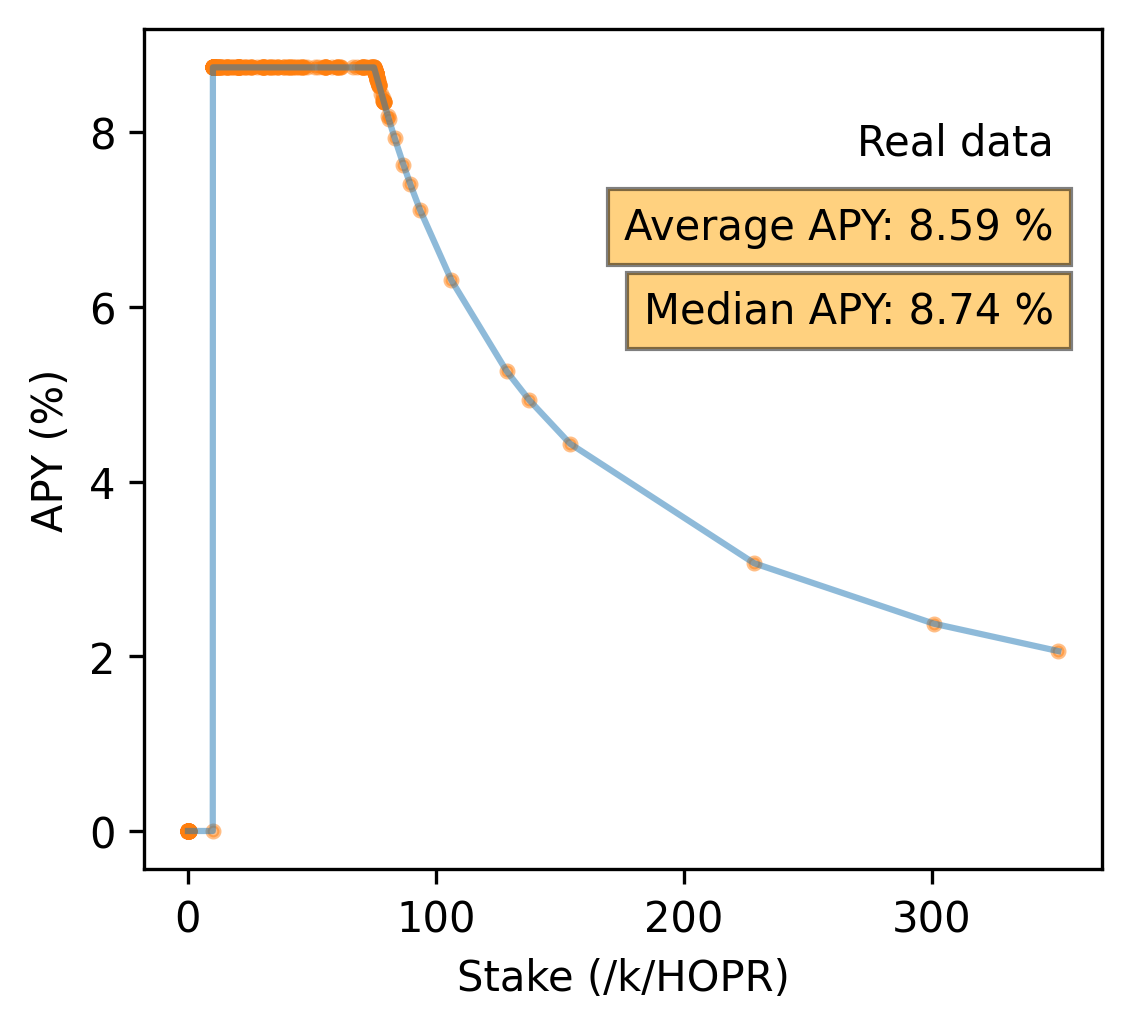

In [35]:

_, axes = plt.subplots(2, 3, figsize=(14, 8), dpi=300, sharey=True)
axes = axes.flatten()
options = deepcopy(prefered_vars)

for opt, ax in zip(options, axes):
    stakes = sorted(data)

    lin_range = np.linspace(0, max(stakes), 1000)

    apys = compute_apy(opt, stakes, percentage=True, average=False, on_stake=True)
    global_apy = probabilistic_apy(data, [opt])[0]["apy"] * 100

    average_apy = np.mean([apy for apy, stake in zip(apys, stakes) if stake > 10e3])
    median_apy = np.median([apy for apy, stake in zip(apys, stakes) if stake > 10e3])

    factor, prefix = factor_and_prefix(stakes[-1])

    stakes = [s/factor for s in stakes]

    ax.plot(stakes, apys, alpha=0.5)
    ax.scatter(stakes, apys, s=8, c="#ff7f0e", alpha=0.5)
    ax.text(0.95,
            0.85,
            opt["legend"],
            transform=ax.transAxes,
            horizontalalignment='right')
    ax.text(0.95,
            0.75,
            f"Average APY: {average_apy:,.2f} %",
            transform=ax.transAxes,
            horizontalalignment='right',
            bbox=dict(facecolor='orange', alpha=0.5),)
    ax.text(0.95,
        0.65,
        f"Median APY: {median_apy:,.2f} %",
        transform=ax.transAxes,
        horizontalalignment='right',
        bbox=dict(facecolor='orange', alpha=0.5),)

    ax.set_xlabel(f"Stake (/{prefix}/HOPR)")
    ax.set_ylabel("APY (%)")

# remove unused subplots
for ax in axes[len(options):]:
    ax.remove()

plt.show()